In [4]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Dierckx, Diffusity

┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [5]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [6]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

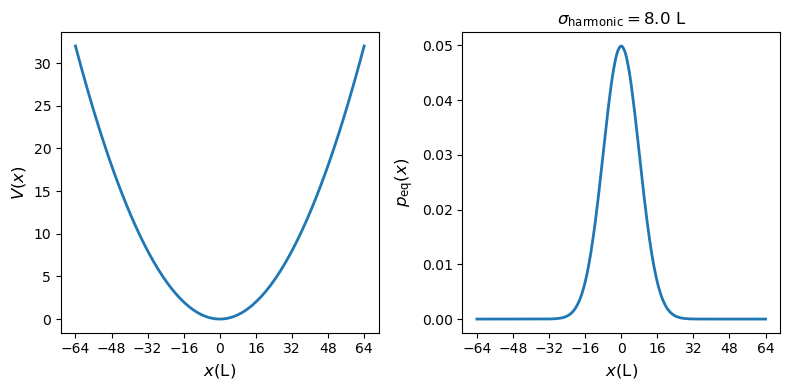

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [7]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [8]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

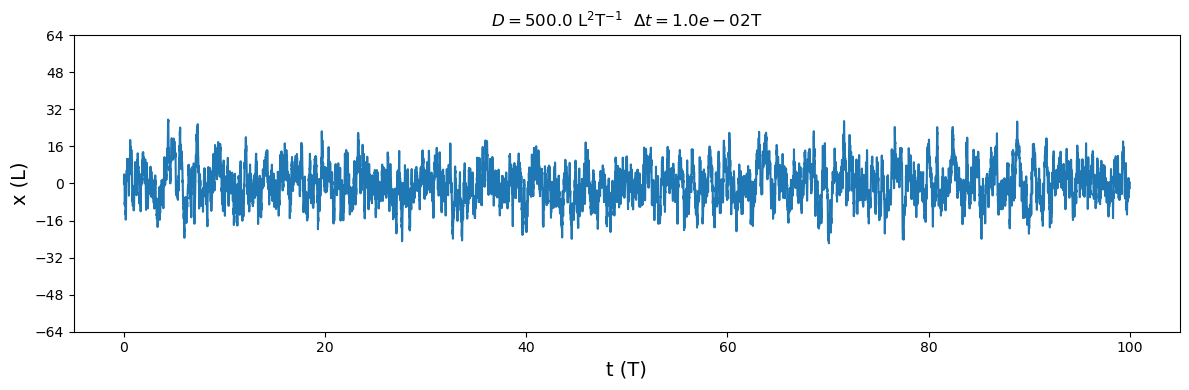

In [7]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4-1: FEM to get $\psi_i$ and $\lambda_i$ when $D=500$

In [9]:
eigenvalues, eigenvect_mat, rho_eq_by_fem = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D, Nv)
weight_Qx = get_weight_Qx(N, Nv, w0, eigenvect_mat);

In [16]:
typeof(eigenvect_mat)

Array{Float64,2}

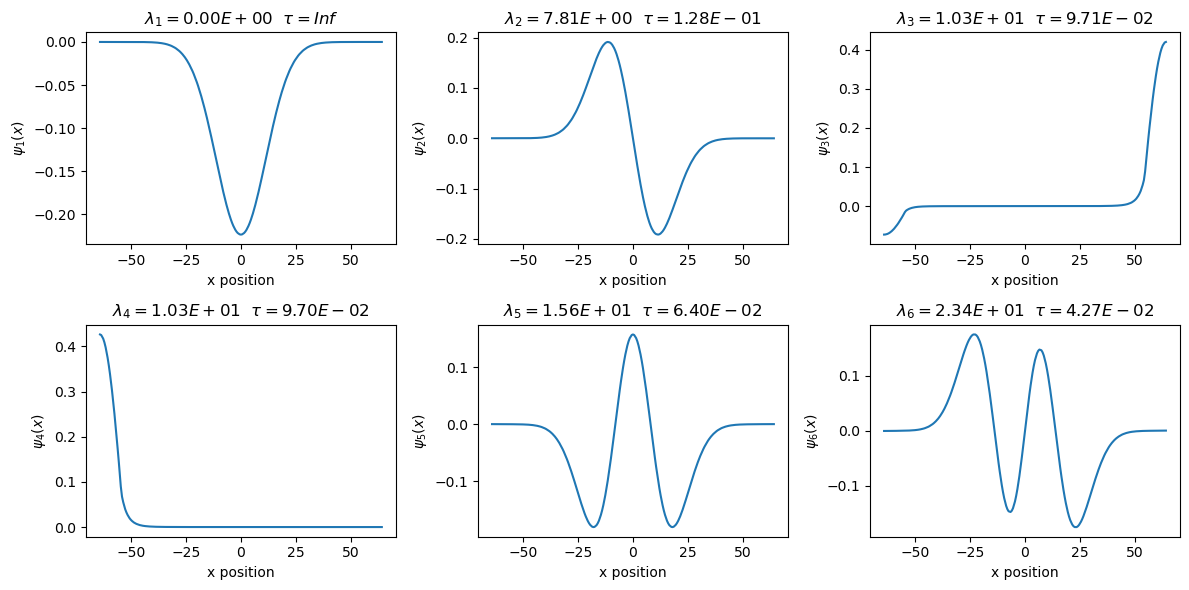

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

idx_eigvector = 1
for row_id = 1:2
    for col_id = 1:3
        plot_x_Qx_lambda(axes[row_id, col_id], idx_eigvector, eigenvalues, eigenvect_mat, xref)
        idx_eigvector += 1
        #axes[row_id, col_id].set_ylim(-0.4, 0.4)
    end
end

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 4-2: FEM to get $\psi'_i$ and $\lambda'_i$ when $D=1$

In [10]:
D_base = 1e0
eigenvalues_0, eigenvect_mat_0, rho_eq_by_fem_0 = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_base, Nv)
weight_Qx_0 = get_weight_Qx(N, Nv, w0, eigenvect_mat);

#### Test $\lambda_i = D\lambda_i' $

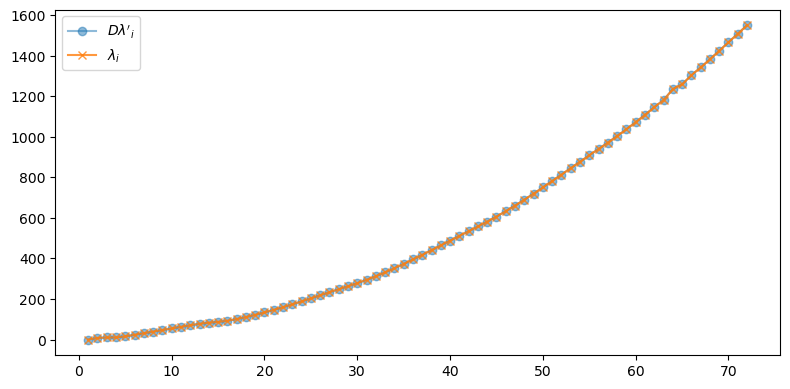

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

xarray = 1:72
ax.plot(xarray, D*eigenvalues_0, "-o", alpha=0.5, label="\$D \\lambda'_i\$")
ax.plot(xarray, eigenvalues, "-x", alpha=0.8, label="\$\\lambda_i\$")
ax.legend()

plt.tight_layout()
plt.show()

### Part 5: $p(x,0)$

In [11]:
σ_delta = 2.0 # 0.8
k_delta = get_k_by_sigma(σ_delta)
idx = find_nearest_point(y_record[1], xref, e_norm, interpo_xs, Np)
p_t0 = get_gaussian(k_delta, xref, idx)
p_t0 = p_t0 / sum(w0 .* p_t0);
#sum(w0 .* p_t0)

alpha_t0_x = sqrt.(p_t0)
alpha_t0 = transpose(weight_Qx) * alpha_t0_x
alpha_t0_norm = norm(alpha_t0)
#sum(alpha_t0_x .* alpha_t0_x .* w0)

0.9999948823284449

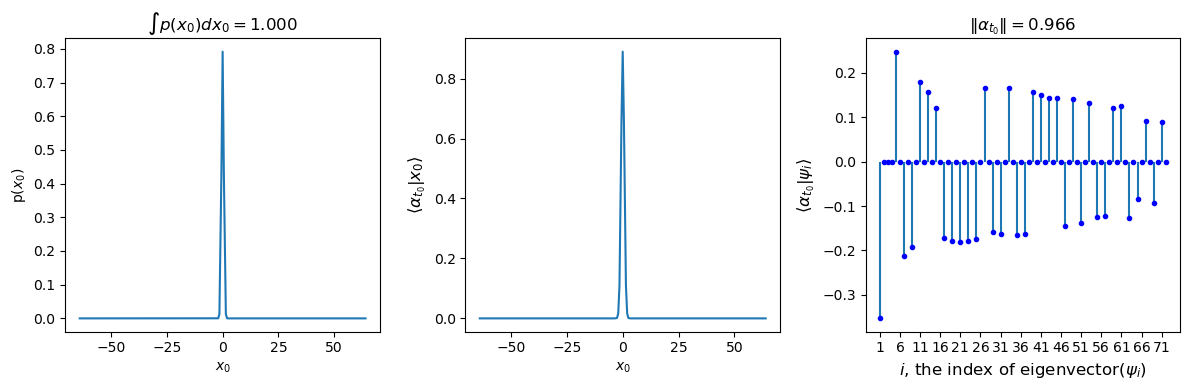

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_t0)
ax.set_ylabel("p(\$x_0\$)")
ax.set_xlabel("\$x_0\$")
title = @sprintf "\$ \\int p(x_0)dx_0=%.3f \$" sum(alpha_t0_x .* alpha_t0_x .* w0)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, alpha_t0_x)
ax.set_xlabel("\$x_0\$")
ax.set_ylabel("\$\\langle \\alpha_{t_0} | x_0 \\rangle\$", fontsize=12)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_0} | \\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\alpha_{t_0} \\Vert =%.3f \$" alpha_t0_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t0_v0.pdf")
plt.show()

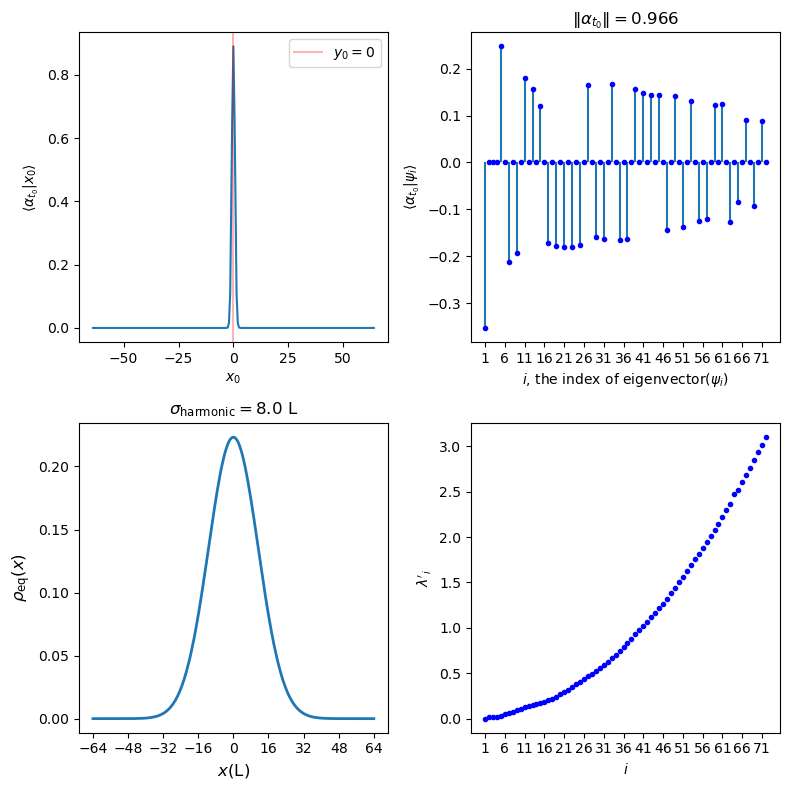

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

ax = axes[1,1]
ax.plot(xref, alpha_t0_x)
ax.axvline(y_record[1], color="red", alpha=0.3, label=@sprintf "\$y_0=%.0f\$" y_record[1])
ax.set_xlabel("\$x_0\$")
ax.set_ylabel("\$\\langle \\alpha_{t_0} | x_0 \\rangle\$")
ax.legend()

ax = axes[1,2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_0} | \\psi_i \\rangle\$")
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)")
title = @sprintf "\$  \\Vert \\alpha_{t_0} \\Vert =%.3f \$" alpha_t0_norm
ax.set_title(title)

ax = axes[2,1]
ax.plot(xref, rho_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$\\rho_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

ax = axes[2,2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, eigenvalues_0, "b.")
ax.set_xticks(xticks)
ax.set_ylabel("\$\\lambda'_i\$")
ax.set_xlabel("\$ i \$")

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t0_v0.svg")
plt.show()

### Part 6: $\left< \hat{\alpha}_{t_{0}} \right| e^{-\textbf{H}\Delta t}$

In [47]:
expLQDT = exp.(-eigenvalues .* save_freq)
alpha_t0_e_delta_t = expLQDT .* alpha_t0;
alpha_t0_e_delta_t_norm = norm(alpha_t0_e_delta_t)
alpha_t0_e_delta_t_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t0_e_delta_t);
p_t0_e_delta_t = alpha_t0_e_delta_t_x .* alpha_t0_e_delta_t_x
sum(w0 .* p_t0_e_delta_t)

0.717284815416238

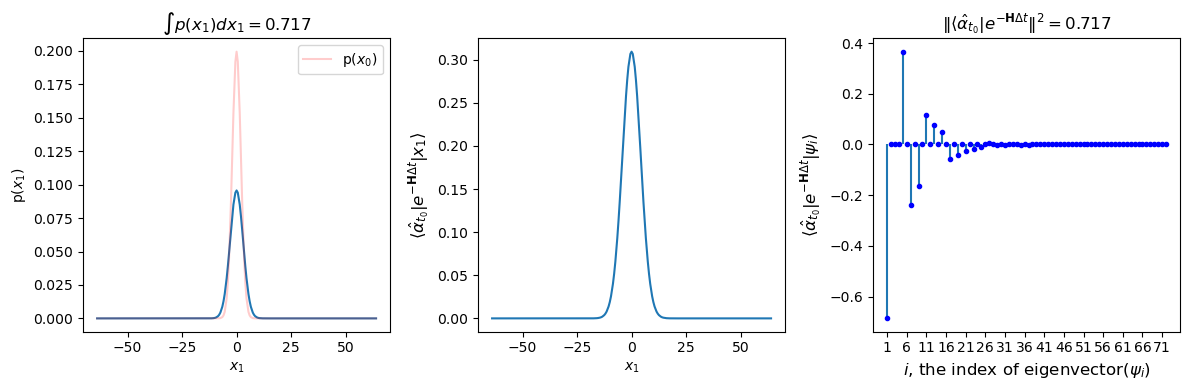

In [47]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_t0_e_delta_t)
ax.plot(xref, p_t0, alpha=0.2, color="red", label="p(\$x_0\$)")
ax.set_ylabel("p(\$x_1\$)")
ax.set_xlabel("\$x_1\$")
title = @sprintf "\$ \\int p(x_1)dx_1=%.3f \$" sum(w0 .* p_t0_e_delta_t)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t0_e_delta_t_x)
ax.set_xlabel("\$x_1\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_0} |e^{-\\mathbf{H}\\Delta t} |x_1 \\rangle\$", fontsize=12)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0_e_delta_t, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0_e_delta_t)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_0} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\langle \\hat{\\alpha}_{t_0} | e^{-\\mathbf{H}\\Delta t} \\Vert^2 =%.3f \$" alpha_t0_e_delta_t_norm.^2
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t0_e_dt_v0.pdf")
plt.show()

### Part 7: $\left< \alpha_{t_1} \right| = \left< \hat{\alpha}_{t_{0}} \right| e^{-\textbf{H}\Delta t} \textbf{y}_1$

In [48]:
alpha_idx = 1
y = y_record[alpha_idx+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_delta)

# < alpha | exp(-H dt) y
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat
alpha_t1 =  psi_photon_psi * alpha_t0_e_delta_t

alpha_t1_norm = norm(alpha_t1)
alpha_t1_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t1)
p_alpha1 = alpha_t1_x .* alpha_t1_x
sum(w0 .* p_alpha1)

0.0026105669866133257

### Photon Matrix Example

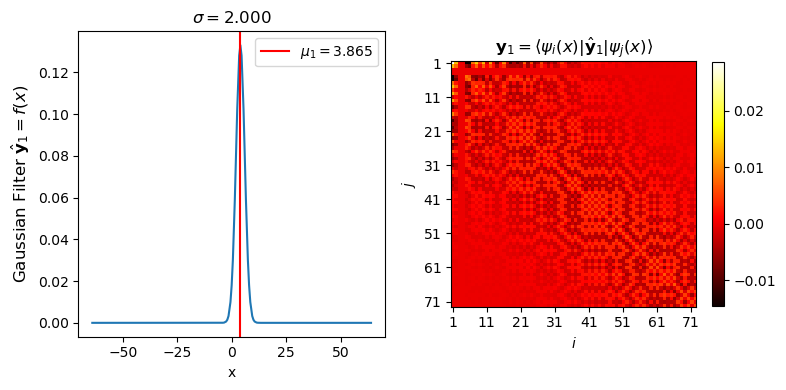

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

ax = axes[1]
y_idx = find_nearest_point(y, xref, e_norm, interpo_xs, Np)
original_gaussian = get_gaussian(k_delta, xref, y_idx)
sigma_photon = 1 / sqrt(2 * k_delta)
ax.plot(xref, original_gaussian)
label = @sprintf "\$ \\mu_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", label=label)
ax.set_xlabel("x")
ylabel = @sprintf "Gaussian Filter \$ \\hat{\\mathbf{y}}_{%d} = f(x) \$" alpha_idx
ax.set_ylabel(ylabel, fontsize=12)
title = @sprintf "\$\\sigma=%.3f\$" sigma_photon
ax.set_title(title)
ax.legend()

ax = axes[2]
im = ax.imshow(psi_photon_psi, cmap="hot")
title = @sprintf "\$ \\mathbf{y}_{%d}  = \\langle \\psi_i(x) | \\hat{\\mathbf{y}}_{%d} | \\psi_j(x) \\rangle \$" alpha_idx alpha_idx
ax.set_title(title)
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70])
ax.set_xticklabels(["1", "11", "21", "31", "41", "51", "61", "71"])
ax.set_yticklabels(["1", "11", "21", "31", "41", "51", "61", "71"])
ax.set_xlabel("\$ i \$")
ax.set_ylabel("\$ j \$")

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/photon_mat_example.pdf")
plt.show()

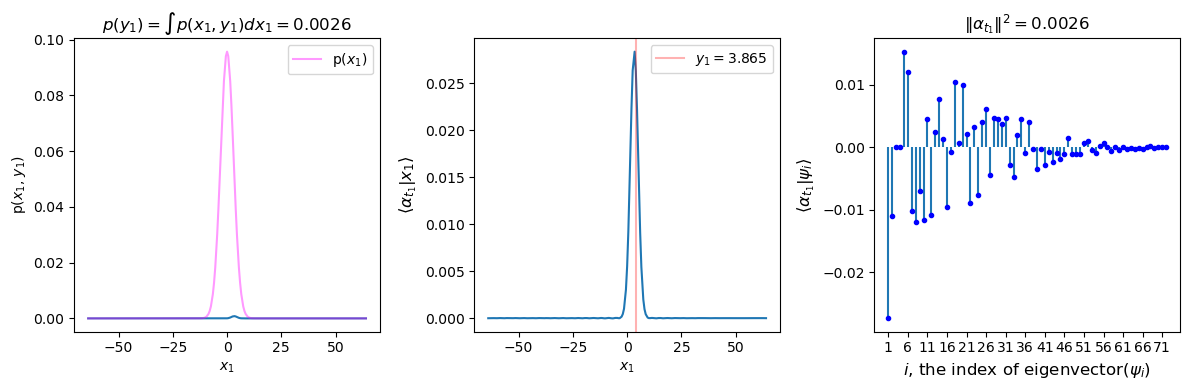

In [49]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha1)
ax.plot(xref, p_t0_e_delta_t, alpha=0.4, color="magenta", label="p(\$x_1\$)")
ax.set_ylabel("p(\$x_1\$, \$y_1\$)")
ax.set_xlabel("\$x_1\$")
title = @sprintf "\$ p(y_1) = \\int p(x_1,y_1)dx_1=%.4f \$" sum(w0 .* p_alpha1)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t1_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_1\$")
ax.set_ylabel("\$\\langle \\alpha_{t_1} |x_1 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t1, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t1)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_1}|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\alpha_{t_1} \\Vert^{2} =%.4f \$" alpha_t1_norm^2
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t1_v0.pdf")
plt.show()

### Part 8: Set D-Array

In [60]:
D_array = 1:5:500;

### Part 9: Compare numerical and analytical $\ln{(p(y_1))}$
- Numerical: $\ln{(\left\lVert\left< \hat{\alpha}_{t_{0}} \right| e^{-\textbf{H}\Delta t} \textbf{y}_1 \right\rVert)}$

In [61]:
l_array_numerical = zeros(length(D_array))
idx = 1
for D_temp in D_array
    expLQDT = exp.(-(D_temp * eigenvalues_0) .* save_freq)
    alpha_t0_e_delta_t = expLQDT .* alpha_t0
    alpha_t1 =  psi_photon_psi * alpha_t0_e_delta_t
    l_array_numerical[idx] = 2 * log(norm(alpha_t1))
    idx += 1
end

- Analytical: $\ln{(p(y_1))} = \ln{(\sum_{j=1}^{72}f^2_j(D))}$

In [62]:
l_array_analytical = [Diffusity.get_l_by_fjD(D_temp, eigenvalues_0, save_freq, Nv, alpha_t0, psi_photon_psi) for D_temp in D_array];

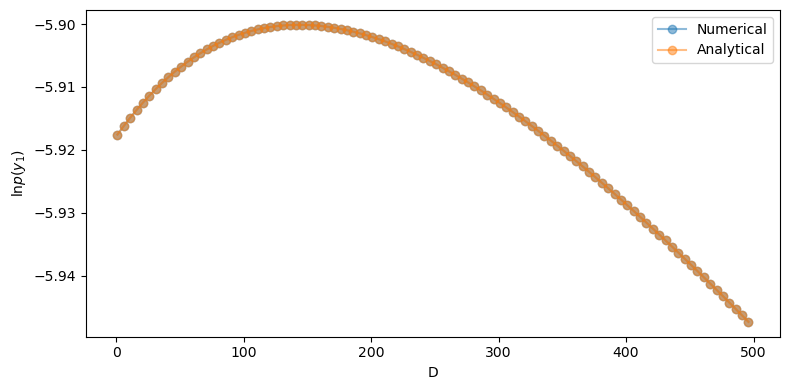

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

xarray = 1:72
ax.plot(D_array, l_array_numerical, "-o", alpha=0.5, label="Numerical")
ax.plot(D_array, l_array_analytical, "-o", alpha=0.5, label="Analytical")

ax.legend()
ax.set_xlabel("D")
ax.set_ylabel("\$\\ln{p(y_1)}\$")

plt.tight_layout()
plt.show()

### Part 9: Compare numerical and analytical $\frac{d\ln{(p(y_1))}}{dD}$

#### Numerical

In [64]:
l_spl = Spline1D(D_array, l_array_numerical)
length_D = length(D_array)
dldD_array_numerical = zeros(length_D)
for idx = 1:length_D
    dldD_array_numerical[idx] = derivative(l_spl, D_array[idx])
end

#### Analytical
\begin{equation}
    \frac{d g(D)}{dD} = 2 \sum_{j=1}^{72} \left[ \left( \sum_{i=1}^{N_v}e^{-D\lambda'_i\Delta t}B_{ij} \right) \left(  \sum_{i=1}^{N_v} -\lambda'_i \Delta t  e^{-D\lambda'_i\Delta t} B_{ij}  \right) \right]
\end{equation}

In [65]:
dldD_array_analytical = [Diffusity.get_l_derivative(D_temp, eigenvalues_0, save_freq, Nv, alpha_t0, psi_photon_psi) for D_temp in D_array];

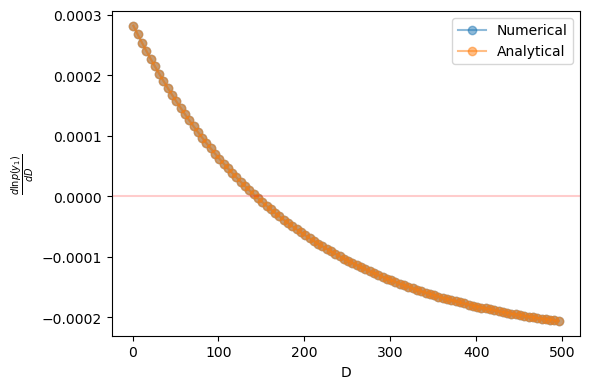

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

ax.plot(D_array, dldD_array_numerical, "-o", alpha=0.5, label="Numerical")
ax.plot(D_array, dldD_array_analytical, "-o", alpha=0.5, label="Analytical")
ax.axhline(0, color="red", alpha=0.2)
ax.legend()
ax.set_xlabel("D")
ax.set_ylabel("\$\\frac{d\\ln{p(y_1)}}{d D}\$")

plt.tight_layout()
plt.show()

### Part 10: Taylor expansion

In [67]:
dldD_array_taylor_v0 = [Diffusity.get_l_derivative_taylor_v0(D_temp, eigenvalues_0, save_freq, Nv, alpha_t0, psi_photon_psi) for D_temp in D_array];
dldD_array_taylor_v1 = [Diffusity.get_l_derivative_taylor_v1(D_temp, eigenvalues_0, save_freq, Nv, alpha_t0, psi_photon_psi) for D_temp in D_array];

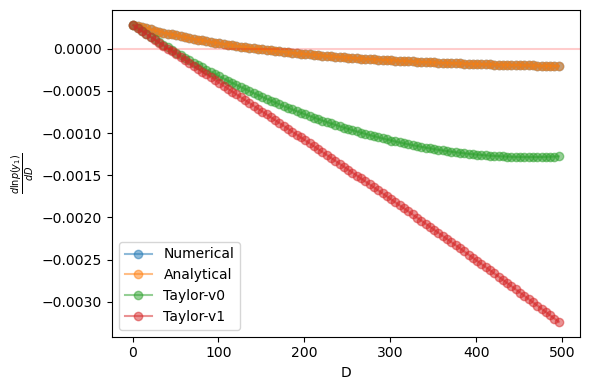

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

ax.plot(D_array, dldD_array_numerical, "-o", alpha=0.5, label="Numerical")
ax.plot(D_array, dldD_array_analytical, "-o", alpha=0.5, label="Analytical")
ax.plot(D_array, dldD_array_taylor_v0, "-o", alpha=0.5, label="Taylor-v0")
ax.plot(D_array, dldD_array_taylor_v1, "-o", alpha=0.5, label="Taylor-v1")

ax.axhline(0, color="red", alpha=0.2)
ax.legend()
ax.set_xlabel("D")
ax.set_ylabel("\$\\frac{d\\ln{p(y_1)}}{d D}\$")

plt.tight_layout()
#plt.savefig("taylor_try.pdf")
plt.show()